In [1]:
import os
os.environ['HF_HOME'] = '/om/user/ericjm/.cache/huggingface'
import argparse

from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn

from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer
import datasets
from huggingface_hub import hf_hub_download, notebook_login

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [2]:
# set grads to off
torch.set_grad_enabled(False)

In [3]:
class JumpReLUSAE(nn.Module):
    def __init__(self, d_model, d_sae):
        # Note that we initialise these to zeros because we're loading in pre-trained weights.
        # If you want to train your own SAEs then we recommend using blah
        super().__init__()
        self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
        self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
        self.threshold = nn.Parameter(torch.zeros(d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))
        self.b_dec = nn.Parameter(torch.zeros(d_model))

    def encode(self, input_acts):
        pre_acts = input_acts @ self.W_enc + self.b_enc
        mask = (pre_acts > self.threshold)
        acts = mask * torch.nn.functional.relu(pre_acts)
        return acts

    def decode(self, acts):
        return acts @ self.W_dec + self.b_dec

    def forward(self, acts):
        acts = self.encode(acts)
        recon = self.decode(acts)
        return recon

def gather_residual_activations(model, target_layer, inputs):
    target_act = None
    def gather_target_act_hook(mod, inputs, outputs):
        nonlocal target_act # make sure we can modify the target_act from the outer scope
        target_act = outputs[0]
        return outputs
    handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
    _ = model.forward(inputs)
    handle.remove()
    return target_act


In [4]:
args = argparse.Namespace()
args.model = "google/gemma-2-2b"
args.layer = 12
args.sae_name = "layer_12/width_16k/average_l0_41"
args.k = 256
args.n_docs = 50_000

In [5]:
DATASET = "monology/pile-uncopyrighted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32 
device_map = {'': 0} if device.type == 'cuda' else None

print("Loading model...")
model = AutoModelForCausalLM.from_pretrained(
    args.model,
    device_map=device_map,
    torch_dtype=dtype,
    low_cpu_mem_usage=True,
)
tokenizer =  AutoTokenizer.from_pretrained(args.model)

Loading model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
if args.model == "google/gemma-2-2b":
    repo_id = "google/gemma-scope-2b-pt-res"
elif args.model == "google/gemma-2-9b":
    repo_id = "google/gemma-scope-9b-pt-res"
path_to_params = hf_hub_download(
    repo_id=repo_id,
    filename=args.sae_name + "/params.npz",
    force_download=False,
    revision="0127b340ca980c3ee81df0275cea35f350f83488",
)

print("Loading SAE from disk...")
params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}

sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1])
sae.load_state_dict(pt_params)

sae.to(device)
sae.eval()

Loading SAE from disk...


JumpReLUSAE()

In [7]:
print("Loading dataset...")
dataset = datasets.load_dataset(DATASET, streaming=True, split="train")

Loading dataset...


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
W_dec_tsne = np.load("W_dec_tsne_gemma-2-2b_res_layer_12_width_16k_average_l0_41.npy")

In [9]:
# load up occurrence and co-occurrence data
occurrence_npz = np.load(f"../experiments/all-occurrences0/histograms/pile_{args.model.replace('/', '_')}_res_{args.sae_name.replace('/', '_')}_occurrences.npz")
occurrence_hist, occurrence_n_tokens = occurrence_npz['histogram'], occurrence_npz['n_tokens']

In [10]:
n_clusterss = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
clustering_results_phi = {}
for n_clusters in n_clusterss:
    clustering_results_phi[n_clusters] = np.load(f"../experiments/all-occurrences0/lily/phi/layer_12_{n_clusters}.npy")

In [11]:
frequencies = occurrence_hist / occurrence_n_tokens
frequencies[frequencies == 0] = 1e-7

(-57.96066398620606, 54.101273727416995, -47.08945198059082, 43.15426368713379)

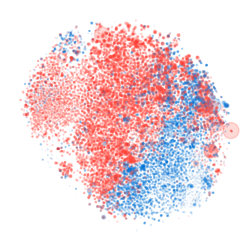

In [12]:
colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
          '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']

n_clusters = 2

plt.figure(figsize=(3, 3))

clusters = clustering_results_phi[n_clusters]
cs = [colors[clusteri] for clusteri in clusters]
cs = np.array(cs)
n_splits = 20
splits = np.array_split(np.random.permutation(len(clusters)), n_splits)
for split in splits:
    plt.scatter(W_dec_tsne[split, 0], W_dec_tsne[split, 1], 
        s=frequencies[split]*3e2,
        color=cs[split], 
        alpha=0.2)
plt.axis('off')

# plt.tight_layout(pad=0.1)

In [13]:
top = '''
import hashlib
import random

# secp256k1 curve parameters
p = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFC2F
n = 0xFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEBAAEDCE6AF48A03BBFD25E8CD0364141
G = (0x79BE667EF9DCBBAC55A06295CE870B07029BFCDB2DCE28D959F2815B16F81798,
     0x483ADA7726A3C4655DA4FBFC0E1108A8FD17B448A68554199C47D08FFB10D4B8)
'''

code = '''
def mod_inv(a, n):
    """Modular multiplicative inverse"""
    def egcd(a, b):
        if a == 0:
            return b, 0, 1
        else:
            g, y, x = egcd(b % a, a)
            return g, x - (b // a) * y, y
    
    g, x, _ = egcd(a, n)
    if g != 1:
        raise Exception('Modular inverse does not exist')
    else:
        return x % n

def point_add(P, Q):
    """Add two points on the curve"""
    if P == Q:
        return point_double(P)
    if P is None:
        return Q
    if Q is None:
        return P
    x1, y1 = P
    x2, y2 = Q
    if x1 == x2 and y1 != y2:
        return None
    m = ((y2 - y1) * mod_inv(x2 - x1, p)) % p
    x3 = (m * m - x1 - x2) % p
    y3 = (m * (x1 - x3) - y1) % p
    return (x3, y3)

def point_double(P):
    """Double a point on the curve"""
    if P is None:
        return None
    x, y = P
    m = ((3 * x * x) * mod_inv(2 * y, p)) % p
    x3 = (m * m - 2 * x) % p
    y3 = (m * (x - x3) - y) % p
    return (x3, y3)

def scalar_mult(k, P):
    """Scalar multiplication of a point"""
    R = None
    for i in range(256):
        if (k >> i) & 1:
            R = point_add(R, P)
        P = point_double(P)
    return R

def generate_keypair():
    """Generate a new public/private key pair"""
    private_key = random.randrange(1, n)
    public_key = scalar_mult(private_key, G)
    return private_key, public_key

def sign(message, private_key):
    """Sign a message using ECDSA"""
    z = int(hashlib.sha256(message.encode('utf-8')).hexdigest(), 16)
    r, s = 0, 0
    while r == 0 or s == 0:
        k = random.randrange(1, n)
        x, y = scalar_mult(k, G)
        r = x % n
        s = (mod_inv(k, n) * (z + r * private_key)) % n
    return (r, s)

def verify(message, signature, public_key):
    """Verify an ECDSA signature"""
    r, s = signature
    z = int(hashlib.sha256(message.encode('utf-8')).hexdigest(), 16)
    w = mod_inv(s, n)
    u1 = (z * w) % n
    u2 = (r * w) % n
    x, y = point_add(scalar_mult(u1, G), scalar_mult(u2, public_key))
    return r == x % n

# Example usage
private_key, public_key = generate_keypair()
message = "Hello, ECDSA!"
signature = sign(message, private_key)
is_valid = verify(message, signature, public_key)

print(f"Message: {message}")
print(f"Signature: {signature}")
print(f"Is Valid: {is_valid}")
'''

poetry = '''
# The Essence of Poetry

Verses dance upon the page,
A rhythm born of silent rage,
Or whispered love, or wonder's gaze—
Each line a world, each word a maze.

Metaphors bloom like spring's first flower,
Similes grant comparisons power,
Alliteration's playful tune
Sings softly 'neath a paper moon.

Stanzas build like ancient towers,
Each level climbing higher, higher,
Towards a truth both old and new,
A perspective fresh, a vantage true.

Sonnets speak of love's sweet ache,
While haikus of moments partake,
Free verse breaks all known chains,
As epic poems weave heroic reigns.

In meter's pulse, we find a beat,
That marches time with steady feet,
Iambs rise and trochees fall,
Anapests answer dactyls' call.

Rhyme schemes lock lines in embrace,
ABAB in familiar grace,
Or AABB's couplets tight,
Or free rhyme's unpredictable flight.

Enjambment leaps from line to line,
Thoughts unbroken, intertwined,
While caesuras pause mid-verse,
For emphasis or to rehearse.

Imagery paints with words alone,
Vivid scenes from seeds thus sown,
Synesthesia blends the senses,
As metaphor breaks down fences.

Poets wield this mighty art,
To heal, to challenge, to impart
The ineffable, the grand, the small—
Poetry encompasses it all.

From Shakespearean heights to Dickenson's quiet,
From Whitman's yawp to Angelou's riot,
Each voice unique, yet part of one
Unending song since time begun.

For poetry is more than words on page,
It's heartbeats, tear drops, and lover's rage,
It's laughter ringing, children at play,
It's twilight fading at end of day.

It's all we've lost and all we've found,
It's silence deep and joyful sound,
It's questions asked and answers sought,
It's battles waged and lessons taught.

In poetry, we find our kin,
Across the miles, across the years,
For in these lines of measured thought,
We recognize our hopes and fears.

So let the verses ever flow,
Let metaphors and meters grow,
For in poetry's eternal art,
We find the essence of the human heart.
'''

In [14]:
video_args = argparse.Namespace()
video_args.save_dir = "twitter-video"
video_args.tokens = 128

In [30]:
os.makedirs(video_args.save_dir, exist_ok=True)

inputs_code = tokenizer.encode(
    code, 
    return_tensors="pt", 
    add_special_tokens=True,
    max_length=video_args.tokens,
    truncation=True
    ).to(device)
target_act = gather_residual_activations(model, args.layer, inputs_code)
sae_acts = sae.encode(target_act)
# convert to 0 or 1 (depending on whether activations are above 1)
sae_acts = (sae_acts > 1) # shape (1, seq_len, d_sae)
sae_acts_code = sae_acts[0, 1:].detach().cpu().numpy() # remove the BOS token
text_tokens_code = tokenizer.batch_decode(inputs_code[0])[1:] # remove the BOS token

inputs_poetry = tokenizer.encode(
    poetry, 
    return_tensors="pt", 
    add_special_tokens=True,
    max_length=video_args.tokens,
    truncation=True
    ).to(device)
target_act = gather_residual_activations(model, args.layer, inputs_poetry)
sae_acts = sae.encode(target_act)
# convert to 0 or 1 (depending on whether activations are above 1)
sae_acts = (sae_acts > 1) # shape (1, seq_len, d_sae)
sae_acts_poetry = sae_acts[0, 1:].detach().cpu().numpy() # remove the BOS token
text_tokens_poetry = tokenizer.batch_decode(inputs_poetry[0])[1:] # remove the BOS token


def format(token):
    newline_tokens = ['\n', '\r', '\r\n', '\v', '\f']
    if all([c in newline_tokens for c in token]):
        # replace all instances with ⏎
        return len(token) * "⏎"
    # replace tabs with \t
    if all([c == '\t' for c in token]):
        return len(token) * "⇥"
    else:
        return token

# create directory for the static images
os.makedirs(os.path.join(video_args.save_dir, f"both-v1"), exist_ok=True)

scales = [0.1, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.1]

# iterate through the figures now
monospace_font = FontProperties(family='monospace')
for i in tqdm(range(min(sae_acts_code.shape[0], sae_acts_poetry.shape[0]))):

    for scalei, scale in enumerate(scales):

        plt.figure(figsize=(10, 5))
        colors = ['#FF4136', '#0074D9', '#FFDC00', '#2ECC40', '#F012BE', 
            '#7FDBFF', '#FF851B', '#01FF70', '#B10DC9', '#FF69B4']
        n_clusters = 2
        clusters = clustering_results_phi[n_clusters]
        cs = [colors[clusteri] for clusteri in clusters]
        cs = np.array(cs)

        plt.subplot(1, 2, 1)
        dead_indices = np.where(~sae_acts_code[i])[0]
        firing_indices = np.where(sae_acts_code[i])[0]
        plt.scatter(
            W_dec_tsne[dead_indices, 0], W_dec_tsne[dead_indices, 1],
            s=frequencies[dead_indices]*1e3,
            color=cs[dead_indices],
            alpha=0.2
        )
        plt.scatter(
            W_dec_tsne[firing_indices, 0], W_dec_tsne[firing_indices, 1],
            # s=np.maximum(frequencies[firing_indices]*2e3, 30),
            s=80 * scale,
            color='yellow',
            alpha=1.0,
            # add black border around point
            edgecolors='black',
            linewidth=0.5    
        )
        # Prepare display tokens
        display_tokens = []
        for j in range(i, max(-1, i-30), -1):
            if sum(len(t) for t in display_tokens) + len(text_tokens_code[j]) < 20:
                display_tokens.insert(0, format(text_tokens_code[j]))
        # Display tokens using annotate
        right_edge = 0.95  # Right alignment position
        y_pos = 0.98  # Vertical position for the text
        # get the current axis
        ax = plt.gca()
        # Start with the rightmost (last) token
        text = ax.text(right_edge, y_pos, display_tokens[-1], 
                        # fontproperties=monospace_font, 
                        color='darkgreen',
                        fontsize=14,
                        transform=ax.transAxes, 
                        ha='right', va='top')
        # Add the rest of the tokens from right to left
        for token in reversed(display_tokens[:-1]):
            text = ax.annotate(
                token, 
                xycoords=text, 
                xy=(0, 0.5),  # Attach to the left middle of the previous text
                xytext=(-5, 0),  # 5 points to the left
                textcoords='offset points',
                va='center', ha='right',
                # fontproperties=monospace_font,
                fontsize=14,
                color='black'
            )
        xmin, xmax = W_dec_tsne[:, 0].min(), W_dec_tsne[:, 0].max()
        ymin, ymax = W_dec_tsne[:, 1].min(), W_dec_tsne[:, 1].max()
        plt.xlim(xmin-6, xmax+6)
        plt.ylim(ymin-4, ymax+8)
        plt.title("Code sample:", fontsize=14)
        plt.axis('off')


        plt.subplot(1, 2, 2)
        dead_indices = np.where(~sae_acts_poetry[i])[0]
        firing_indices = np.where(sae_acts_poetry[i])[0]
        plt.scatter(
            W_dec_tsne[dead_indices, 0], W_dec_tsne[dead_indices, 1],
            s=frequencies[dead_indices]*1e3,
            color=cs[dead_indices],
            alpha=0.2
        )
        plt.scatter(
            W_dec_tsne[firing_indices, 0], W_dec_tsne[firing_indices, 1],
            # s=np.maximum(frequencies[firing_indices]*2e3, 30),
            s=80 * scale,
            color='yellow',
            alpha=1.0,
            # add black border around point
            edgecolors='black',
            linewidth=0.5    
        )
        # Prepare display tokens
        display_tokens = []
        for j in range(i, max(-1, i-30), -1):
            if sum(len(t) for t in display_tokens) + len(text_tokens_poetry[j]) < 20:
                display_tokens.insert(0, format(text_tokens_poetry[j]))
        # Display tokens using annotate
        right_edge = 0.95  # Right alignment position
        y_pos = 0.98  # Vertical position for the text
        # get the current axis
        ax = plt.gca()
        # Start with the rightmost (last) token
        text = ax.text(right_edge, y_pos, display_tokens[-1], 
                        fontproperties=monospace_font, 
                        color='darkgreen',
                        fontsize=14,
                        transform=ax.transAxes, 
                        ha='right', va='top')
        # Add the rest of the tokens from right to left
        for token in reversed(display_tokens[:-1]):
            text = ax.annotate(
                token, 
                xycoords=text, 
                xy=(0, 0.5),  # Attach to the left middle of the previous text
                xytext=(-5, 0),  # 5 points to the left
                textcoords='offset points',
                va='center', ha='right',
                fontproperties=monospace_font,
                fontsize=14,
                color='black'
            )
        xmin, xmax = W_dec_tsne[:, 0].min(), W_dec_tsne[:, 0].max()
        ymin, ymax = W_dec_tsne[:, 1].min(), W_dec_tsne[:, 1].max()
        # plt.xlim(xmin-3, xmax+3)
        # plt.ylim(ymin-2, ymax+5.0)
        plt.xlim(xmin-6, xmax+6)
        plt.ylim(ymin-4, ymax+8)
        plt.axis('off')
        plt.title("Poetry sample:", fontsize=14)

        dummy_scatter1 = plt.scatter([], [], c='#FF4136', s=100, alpha=0.4, label='English text lobe')
        dummy_scatter2 = plt.scatter([], [], c='#0074D9', s=100, alpha=0.4, label='Math & code lobe')
        dummy_scatter3 = plt.scatter([], [], c='yellow', s=100, alpha=1.0, label='Active feature', edgecolors='black', linewidth=0.5)
        fig = plt.gcf()
        fig.legend(loc='center', bbox_to_anchor=(0.5, 0.1), ncol=3, framealpha=1.0)

        plt.savefig(os.path.join(video_args.save_dir, f"both-v1", f"frame_{int(len(scales)*i + scalei)}.png"), dpi=200, bbox_inches='tight')
        # plt.savefig(os.path.join(video_args.save_dir, f"both-v0", f"frame_test{scalei}.png"), dpi=200, bbox_inches='tight')

        plt.close()


  0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    # add a choice of the model, either google/gemma-2-2b or google/gemma-2-9b
    parser.add_argument("--model", type=str, help="The model to use for feature extraction.", default="google/gemma-2-9b", choices=["google/gemma-2-2b", "google/gemma-2-9b"])
    parser.add_argument("--dataset", type=str, help="Path to the corpus to analyze.",
        default="togethercomputer/RedPajama-Data-V2")
    parser.add_argument("--layer", type=int, help="The layer the SAE reconstructs.", default=20)
    parser.add_argument("--sae_name", type=str, help="The name of the SAE to use.", default="layer_20/width_131k/average_l0_19")
    parser.add_argument("--doc", type=int, default=0,help="The document index to process")
    parser.add_argument("--tokens", type=int, help="The number of tokens to process", default=128)
    parser.add_argument("--save_dir", type=str, help="The directory to save the histogram to.", default="videos")
    args = parser.parse_args()
    main(args)

